# Young and elderly classification regardless gait speed in human motion analysis

## Prof. Nikolay Prieto 
*Universidad de San Buenaventura - Sede Bogotá*

We are going to aplpy Artificial Intelligence techniques to classify either the speed of the subject and the age group according to the data given from Ferrarins article [doi](http://dx.doi.org/10.1016/j.gaitpost.2010.08.009).

Also, literature about AI applied on the biomechanics field can be apprecieted in the Figueiredo's paper. In this opportunity we will build an AI algorithm able to classify if the person is young **y** or adult **a**, also in which velocity (Too slow **XS**, Slow **S**, Natural Speed **Natural**, More than normal **M** and fast **L**) 

Let us explain the procedure:



In [0]:
#Loading the root directory and adding my google drive disk
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Simulations/Quasi-stiffness/DJS-Scripts/"

Mounted at /content/gdrive


In [0]:
#Changing to the root directory
import sys
import os
#print(sys.path)
os.chdir(root_dir)
!ls Figures

foot_movements_in_gait.png  movements_in_gait.png  planes_in_gait.png


# Some concepts about Human Gait

## How the planes in human motion are named

![human planes](https://drive.google.com/uc?id=1icMDhWCw_1s4FKYPgSEJYIUX7_Wwo3x1)

## Terminology in movements
![movements in gait](https://drive.google.com/uc?id=1hTtXIwNR7VXbimmYdlbwW4t1eQPFSnXn)

## Terminology only for ankle foot
![foot movements](https://drive.google.com/uc?id=1_kTatzluVRXAC2D1XhaP7X48M02MkUkZ)



In [0]:
import warnings
import numpy as np
import pandas as pd
from bokeh.layouts import row, column
from bokeh.palettes import Spectral6, Set3
from bokeh.plotting import figure, show, gridplot
from bokeh.models import ColumnDataSource
from bokeh.models.glyphs import Text
from bokeh.io import reset_output, output_notebook
from scipy.integrate import simps
import scipy.optimize as optimization
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from DJSFunctions import Plotting
from DJSFunctions import EnergyFunctions
from DJSFunctions import Regressions
from curvature import smoothness
import matplotlib.pyplot as plt
from pathlib import PurePath
import os
warnings.filterwarnings('ignore')
output_notebook()
##Cleaning and selecting the data
reset_output()
current_dir = PurePath(os.getcwd())
data_dir =  os.chdir('../Ferrarin')
FerrarinData =  pd.ExcelFile('mmc3.xls')
labels =  ['Natural_y','XSy','Sy','My','Ly','Toe_y','Heel_y','Ascending_y',
           'Descending_y','Natural_a','XSa','Sa','Ma','La','Toe_a','Heel_a',
           'Ascending_a','Descending_a']
os.chdir(current_dir)
## Building the subtables

In [0]:
sheet_names = pd.Series(FerrarinData.sheet_names[1:])
sheet_names

0           Joint Rotations
1    Ground Reaction Forces
2             Joint Moments
3               Joint Power
4                       EMG
5              Cycle Events
6                Parameters
7                     ANOVA
8                    t-test
dtype: object

In [0]:
#Storing all sheets in one dictionary
complete_data = {i:FerrarinData.parse(i) for i in sheet_names}
#Creating Multiindex pandas either for rows and columns

multi_labels= [labels, ['SD-','mean','SD+']]
#Creating the multi-index for the columns 
columns = pd.MultiIndex.from_product(multi_labels, names=['Speed', 'Measure'])
for j in sheet_names[:5]:
  # Creating the multi-index for the indexes
  labels_index= complete_data[j].iloc[:,0].unique()
  #Getting the cycle percentage
  cycle = complete_data[j].iloc[:,1].unique()
  #Making the multi-index
  multi_index= [labels_index, cycle]
  df_ = complete_data[j]
  rows = pd.MultiIndex.from_product(multi_index, names=[df_.columns[0], 'Gait percentage'])
  #Erasing the first two columns as we 
  df_ = df_.drop(df_.columns[0:2], axis=1)
  df_.columns = columns
  df_.index = rows
  df_
  #Overwriting the data in the bog dict
  complete_data[j] = df_
#Showing samples
complete_data[sheet_names[1]].head(5)

Speed                               Natural_y            ... Descending_a          
Measure                                   SD-      mean  ...         mean       SD+
GRF [% Body Weight] Gait percentage                      ...                       
Anterior/Posterior  0.00             0.000000  0.000000  ...     0.000000  0.000000
                    0.01            -0.072190 -0.025249  ...    -0.015764 -0.000783
                    0.02            -0.107612 -0.055408  ...    -0.046734 -0.017368
                    0.03            -0.184431 -0.115688  ...    -0.054934 -0.026127
                    0.04            -0.210394 -0.152850  ...    -0.060170 -0.029798

[5 rows x 54 columns]

In [0]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from itertools import combinations

#Setting plot parameters
plt.rcParams.update({'font.size': 22})
# Cleaning the plots
plt.cla()
plt.clf()
plt.close()
sd=False
lab = labels[:8]
def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)


def get_mult_num(integer):
  """
  From https://stackoverflow.com/questions/54556363/finding-two-integers-that-multiply-to-20-can-i-make-this-code-more-pythonic
  """
  given_comb = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]
  return [(i, j) for i, j in list(combinations(given_comb,2)) if i * j == integer]
  
def subpl(integer, a=9, dif=3):
  """
  Function to generate the best combination among a number of plots
  It does not work, use_get_mult_num instead
  """
  a_init = a
  b_init = b = a - dif 
  try:
    while lcm(a,b) != integer and a+b >=0:
      print(a,b)
      a -= 1
      b -= 1
  except (ValueError, ZeroDivisionError) as e:
    print('Determining the suitable division could not be done, trying bypairs')
    dif += 1
    a,b = subpl(integer, a=a_init, dif=dif)
  return a,b


In [0]:
def gait_plot(df_, label, sd=False, title=False):
  # Cleaning the plots
  plt.cla()
  plt.clf()
  plt.close()
  
  # Getting the first index in rows
  indexes= df_.index.get_level_values(0).unique()
  #Gait cycle
  x = df_.index.get_level_values(1).unique()
  #nrows, ncols = subpl(len(lab))
  nrows, ncols = get_mult_num(len(indexes))[-1]
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*ncols*2, ncols*nrows), sharex=True)
  # "ravel" flattens the numpy array without making a copy
  for j, ax in enumerate(axs.ravel()):
    for i in label:
      mean = df_[i,'mean'][indexes[j]].values
      sd_min = df_[i,'SD-'][indexes[j]].values
      sd_max = df_[i,'SD+'][indexes[j]].values
      ax.plot(x, mean, '-')
      if sd:
        ax.fill_between(x, sd_min, sd_max, alpha=0.2)
      ax.set_xlabel('Gait cycle [%]')
      ax.set_ylabel(indexes[j]+' [deg]')
  ax.legend(label, loc='center left', bbox_to_anchor=(1, 0.5))
  if title:  plt.suptitle(title)
  plt.show()
  # ax.plot(x, y, 'o', color='tab:brown')
  return

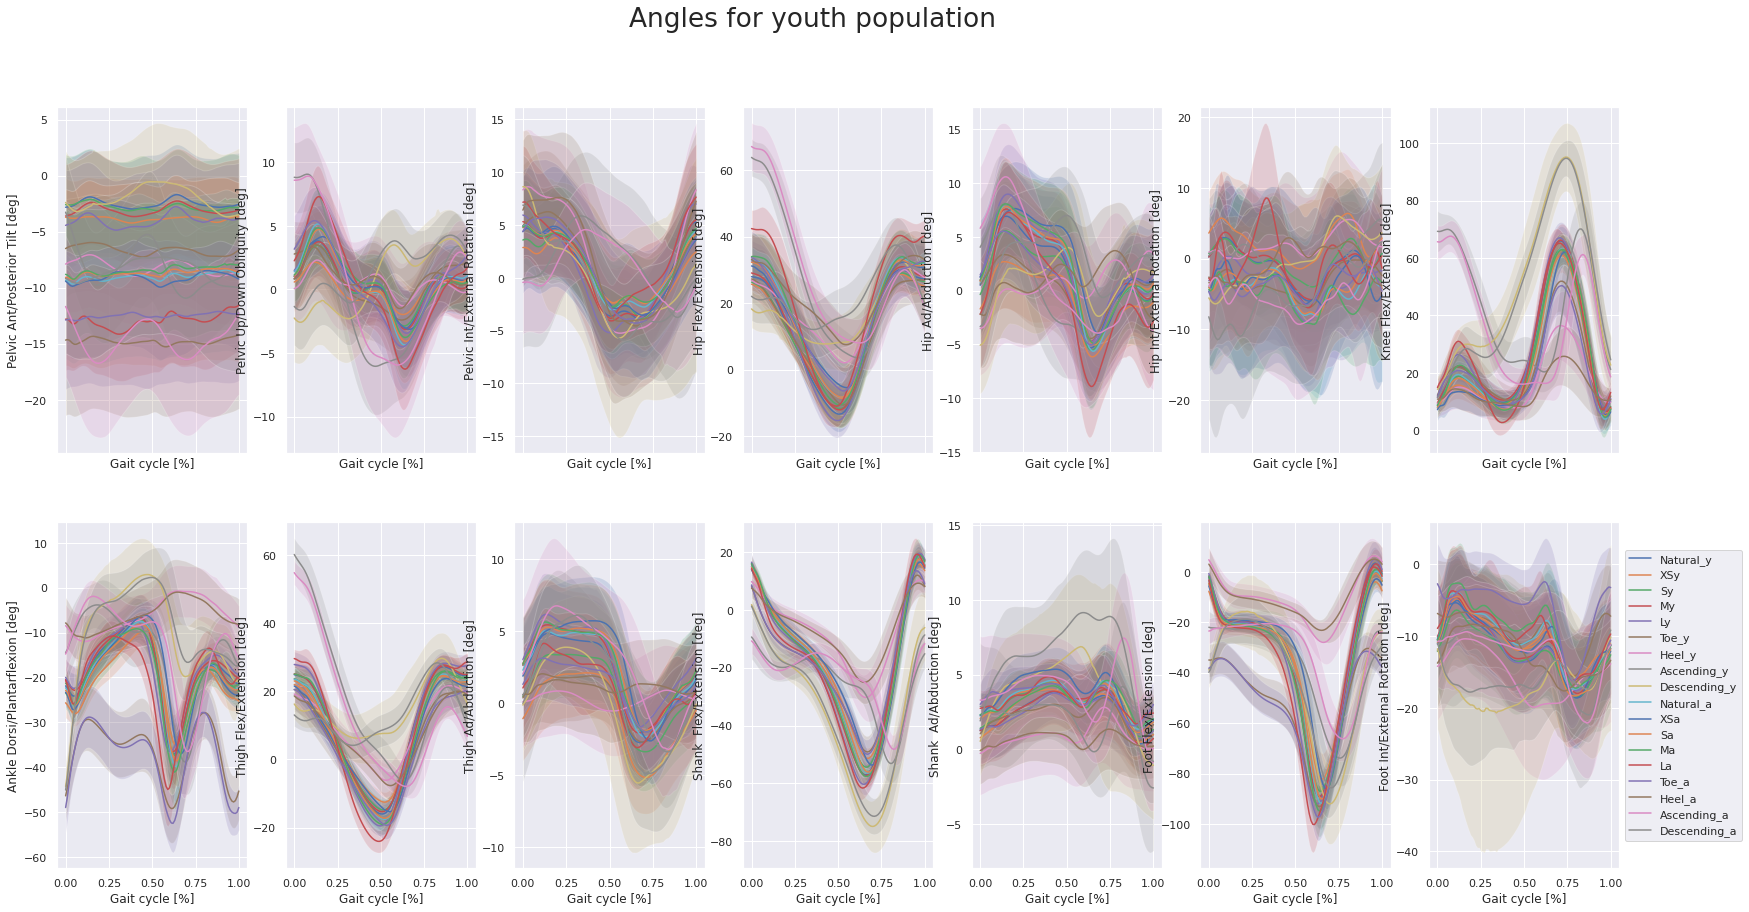

In [0]:
df_ = complete_data[sheet_names[0]]
gait_plot(df_, labels[:], sd=True, title='Angles for youth population')

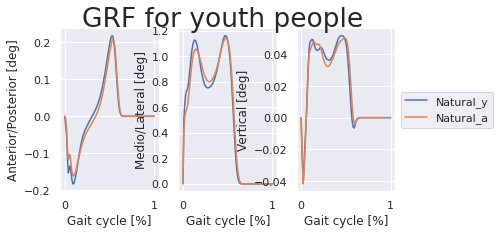

In [0]:
df_ = complete_data[sheet_names[1]]
gait_plot(df_, [labels[0], labels[9]], sd=False, title='GRF for youth people')

In [0]:
##Calling by multi row
idx = pd.IndexSlice
indexes= df_.index.get_level_values(0).unique()
df_['Natural_y'].sample()

,Measure,SD-,mean,SD+
Angle [°],Gait percentage,,,
Foot Flex/Extension,0.13,-23.843987,-20.094845,-16.345703


In [0]:
#Calling by multi index and multirow
df_.loc[idx[:, :], idx[:, 'mean']]


Speed                             Natural_y       XSy  ... Ascending_a Descending_a
Measure                                mean      mean  ...        mean         mean
Muscle [% max]    Gait percentage                      ...                         
Tibialis anterior 0.00             0.252083  0.183974  ...    0.110976     0.086823
                  0.01             0.210620  0.221282  ...    0.113581     0.091037
                  0.02             0.233600  0.208331  ...    0.122048     0.098171
                  0.03             0.293244  0.257641  ...    0.128692     0.103003
                  0.04             0.311699  0.245843  ...    0.183545     0.099180
...                                     ...       ...  ...         ...          ...
Gluteus maximus   0.96             0.099242  0.063567  ...    0.049807     0.058120
                  0.97             0.125459  0.067544  ...    0.048666     0.059892
                  0.98             0.133583  0.083149  ...    0.048341     0.059607
                  0.99             0.130517  0.088325  ...    0.048729     0.062222
                  1.00             0.142370  0.089679  ...    0.049214     0.057722

[808 rows x 18 columns]

## How to use the PCA to classify according to the data

We are going to base on the work done by **Eskofier et al** [3] which abstract is:


> *The classification of gait patterns has great potential as a diagnostic tool, for example, for the diagnosis of injury or to identify at-risk gait in the elderly. The purpose of the paper is to present a method for classifying group differences in gait pattern by using the complete spatial and temporal information of the segment motion quantified by the markers. The classification rates that are obtained are compared with previous studies using conventional classification features. For our analysis, 37 three-dimensional marker trajectories were collected from each of our 24 young and 24 elderly female subjects while they were walking on a treadmill. Principal component analysis was carried out on these trajectories to retain the spatial and temporal information in the markers. Using a Support Vector Machine with a linear kernel, a classification rate of 95.8% was obtained. This classification approach also allowed visualisation of the contribution of individual markers to group differentiation in position and time. The approach made no specific assumptions and did not require prior knowledge of specific time points in the gait cycle. It is therefore directly applicable for group classification tasks in any study involving marker measurements.*



### How the population was set up in the experiment

![population](https://drive.google.com/uc?id=1tPM95BR0RKJXewVQr_FArLogsJabCawz)

### Which were the variables implied in the human gait analysis

![markers](https://drive.google.com/uc?id=1V6qAzovgWS_Hlu8_66dfqGSU_-nuWh9C)

![marker vi](https://drive.google.com/uc?id=1fySK5muO4eubvpkxFPKQEseR-6GNwvxW)

### Which classification algorithm was applied to the problem

![marker viz](https://drive.google.com/uc?id=1Tc0JxEmy-_JFW_0K2SqbwLiEKyCNN52E)

# Your Task


1.   Be familiar with the Anthropometric concepts implied in the dataset.
2.   Rearrange the data so that you can implement a feature extraction process.
Implement a feasible and believable feature extraction process using PCA or kPCA.
3. Perform a multiclass classification process  using your prefered method. 
Determine the number of Principal Components in which you get the highest accuracy.
4. Get your own conclusions



**Plus:** Use the feature importance process to know the most important variables in the process.





[1] G. Bovi, M. Rabuffetti, P. Mazzoleni, M. Ferrarin, A multiple-task gait analysis approach: Kinematic, kinetic and EMG reference data for healthy young and adult subjects, Gait Posture. 33 (2011) 6–13. https://doi.org/10.1016/j.gaitpost.2010.08.009.

[2] J. Figueiredo, C.P. Santos, J.C. Moreno, Automatic recognition of gait patterns in human motor disorders using machine learning: A review, Med. Eng. Phys. 53 (2018) 1–12. https://doi.org/10.1016/j.medengphy.2017.12.006.

[3] B.M. Eskofier, P. Federolf, P.F. Kugler, B.M. Nigg, Marker-based classification of young-elderly gait pattern differences via direct PCA feature extraction and SVMs, Comput. Methods Biomech. Biomed. Engin. 16 (2013) 435–442. https://doi.org/10.1080/10255842.2011.624515.

[4] M.W. Whittle, Gait Analysis an Introduction, 4th ed., Elsevier, 2007.
